### Projekt API - rozróżnianie gatunków muzycznych na podstawie tekstu utworów

### 1. Import zbioru danych

In [1]:
# import podstawowych bibliotek
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re
import random

# rozne modele ML
from sklearn.feature_extraction import text      
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

# globane parametry do testów
SONGS_PER_GENRE = 20000
SONGS_PER_TRAINING = 2000
SONGS_PER_TESTING = 200

In [2]:
songs = pd.read_csv('lyrics.csv') #importujemy liste piosenek
songs.head(10)

,ALink,SName,SLink,Lyric,Idiom
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH
5,/10000-maniacs/,Don't Talk,/10000-maniacs/dont-talk.html,"Don't talk, I will listen. Don't talk, you kee...",ENGLISH
6,/10000-maniacs/,Across The Fields,/10000-maniacs/across-the-fields.html,"Well they left then in the morning, a hundred ...",ENGLISH
7,/10000-maniacs/,Planned Obsolescence,/10000-maniacs/planned-obsolescence.html,[ music: Dennis Drew/lyric: Natalie Merchant ]...,ENGLISH
8,/10000-maniacs/,Rainy Day,/10000-maniacs/rainy-day.html,On bended kneeI've looked through every window...,ENGLISH
9,/10000-maniacs/,Anthem For Doomed Youth,/10000-maniacs/anthem-for-doomed-youth.html,For whom do the bells toll. When sentenced to ...,ENGLISH


In [3]:
artists = pd.read_csv('artists.csv') #importujemy liste artystow
artists=artists.drop(['Popularity','Genres'], axis=1)
artists=artists.rename(columns={'Link': 'ALink'})
artists.head(10)

,Artist,Songs,ALink,Genre
0,10000 Maniacs,110,/10000-maniacs/,Rock
1,12 Stones,75,/12-stones/,Rock
2,311,196,/311/,Rock
3,4 Non Blondes,15,/4-non-blondes/,Rock
4,A Cruz Está Vazia,13,/a-cruz-esta-vazia/,Rock
5,Aborto Elétrico,36,/aborto-eletrico/,Rock
6,Abril,36,/abril/,Rock
7,Abuse,13,/abuse/,Rock
8,AC/DC,192,/ac-dc/,Rock
9,ACEIA,0,/aceia/,Rock


In [4]:
#łączymy oba importy
merged_inner=pd.merge(left=artists, right=songs, left_on='ALink', right_on='ALink')
merged_inner.head(10)

,Artist,Songs,ALink,Genre,SName,SLink,Lyric,Idiom
0,10000 Maniacs,110,/10000-maniacs/,Rock,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,10000 Maniacs,110,/10000-maniacs/,Rock,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,10000 Maniacs,110,/10000-maniacs/,Rock,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,10000 Maniacs,110,/10000-maniacs/,Rock,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,10000 Maniacs,110,/10000-maniacs/,Rock,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH
5,10000 Maniacs,110,/10000-maniacs/,Rock,Don't Talk,/10000-maniacs/dont-talk.html,"Don't talk, I will listen. Don't talk, you kee...",ENGLISH
6,10000 Maniacs,110,/10000-maniacs/,Rock,Across The Fields,/10000-maniacs/across-the-fields.html,"Well they left then in the morning, a hundred ...",ENGLISH
7,10000 Maniacs,110,/10000-maniacs/,Rock,Planned Obsolescence,/10000-maniacs/planned-obsolescence.html,[ music: Dennis Drew/lyric: Natalie Merchant ]...,ENGLISH
8,10000 Maniacs,110,/10000-maniacs/,Rock,Rainy Day,/10000-maniacs/rainy-day.html,On bended kneeI've looked through every window...,ENGLISH
9,10000 Maniacs,110,/10000-maniacs/,Rock,Anthem For Doomed Youth,/10000-maniacs/anthem-for-doomed-youth.html,For whom do the bells toll. When sentenced to ...,ENGLISH


In [5]:
#weryfikacja kolumn po złączeniu plików
import datatest as dt

dt.validate(merged_inner.columns, {'Artist', 'Songs', 'ALink', 'Genre', 'SName', 'SLink', 'Lyric', 'Idiom'})

In [6]:
#testy jednostowe
import unittest

class TestMyData(dt.DataTestCase):

    def test_column_names(self):
        required_names = {'Artist', 'Songs', 'ALink', 'Genre', 'SName', 'SLink', 'Lyric', 'Idiom'}
        self.assertValid(merged_inner.columns, required_names)

In [7]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_column_names (__main__.TestMyData) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


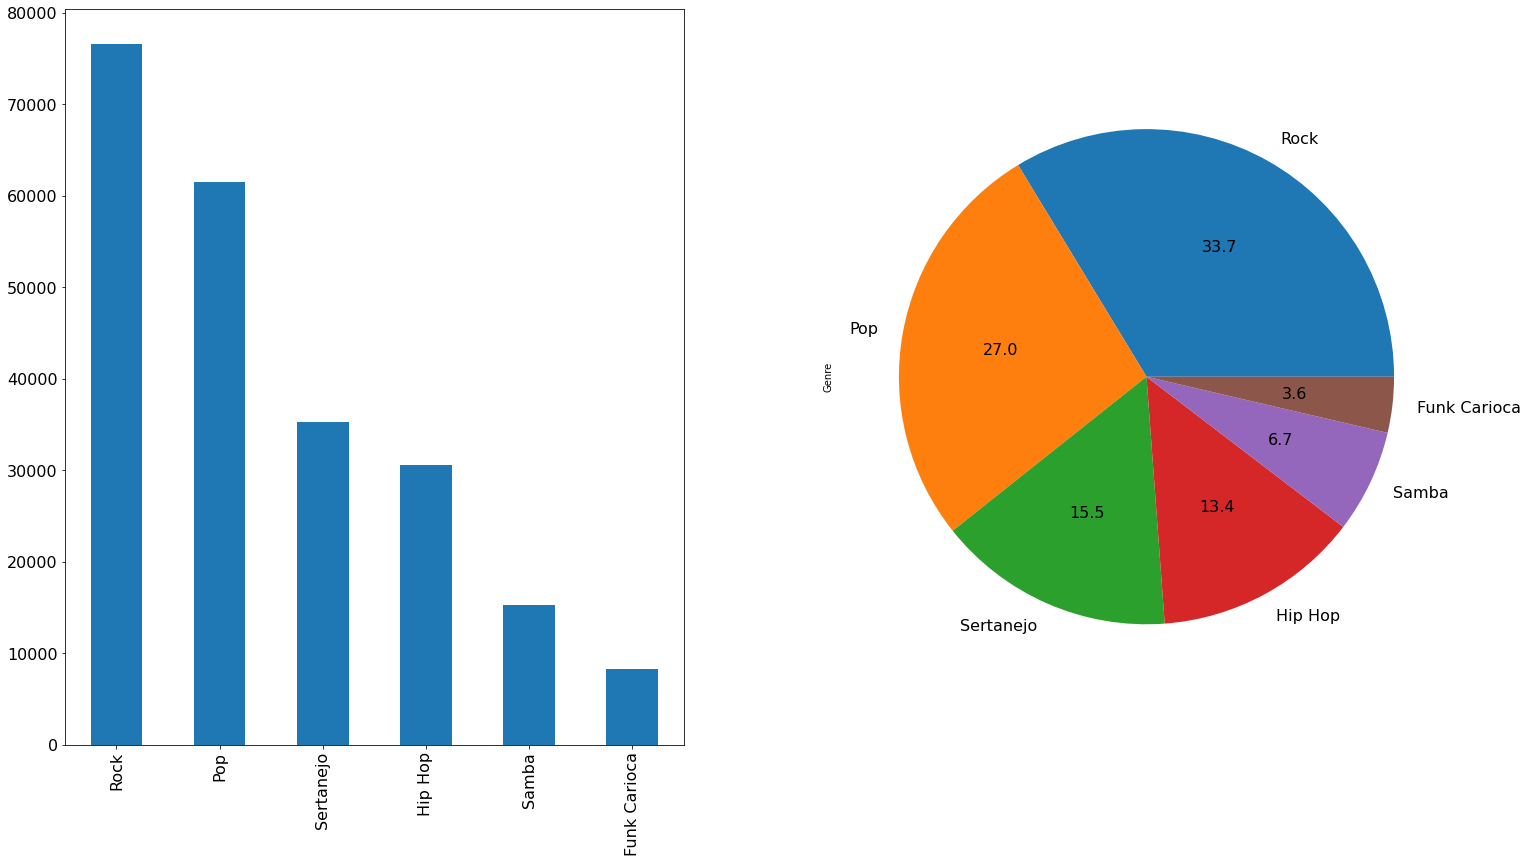

In [8]:
#procentowy rozklad wszystkich gatunkow muzycznych w zbiorze danych

genreCount = merged_inner['Genre'].value_counts()
fig, axarr = plt.subplots(1, 2)
fig.tight_layout()
genreCount.plot.pie( figsize=(12, 12), ax=axarr[1], fontsize=16, autopct='%.1f' )
genreCount.plot.bar( figsize=(22, 12), ax=axarr[0], fontsize=16 )
plt.show()

In [9]:
# szybkie filtorwanie danych, tak aby ostatecznie rozroniac teksty miedzy ROCKiem a HIP HOPem
df_filtered = merged_inner[merged_inner['Idiom'] == 'ENGLISH']
df_filtered = df_filtered[df_filtered['Genre'] != 'Samba']
df_filtered = df_filtered[df_filtered['Genre'] != 'Sertanejo']
df_filtered = df_filtered[df_filtered['Genre'] != 'Funk Carioca']
df_filtered = df_filtered[df_filtered['Genre'] != 'Pop']
merged_inner = df_filtered
df_filtered.head(10)

,Artist,Songs,ALink,Genre,SName,SLink,Lyric,Idiom
0,10000 Maniacs,110,/10000-maniacs/,Rock,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,10000 Maniacs,110,/10000-maniacs/,Rock,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,10000 Maniacs,110,/10000-maniacs/,Rock,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,10000 Maniacs,110,/10000-maniacs/,Rock,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,10000 Maniacs,110,/10000-maniacs/,Rock,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH
5,10000 Maniacs,110,/10000-maniacs/,Rock,Don't Talk,/10000-maniacs/dont-talk.html,"Don't talk, I will listen. Don't talk, you kee...",ENGLISH
6,10000 Maniacs,110,/10000-maniacs/,Rock,Across The Fields,/10000-maniacs/across-the-fields.html,"Well they left then in the morning, a hundred ...",ENGLISH
7,10000 Maniacs,110,/10000-maniacs/,Rock,Planned Obsolescence,/10000-maniacs/planned-obsolescence.html,[ music: Dennis Drew/lyric: Natalie Merchant ]...,ENGLISH
8,10000 Maniacs,110,/10000-maniacs/,Rock,Rainy Day,/10000-maniacs/rainy-day.html,On bended kneeI've looked through every window...,ENGLISH
9,10000 Maniacs,110,/10000-maniacs/,Rock,Anthem For Doomed Youth,/10000-maniacs/anthem-for-doomed-youth.html,For whom do the bells toll. When sentenced to ...,ENGLISH


In [10]:
#testy jednostowe
import unittest

class TestStringMethods(unittest.TestCase):

    def test_upper(self):
        self.assertEqual('Lyrics'.upper(), 'LYRICS')

    def test_isupper(self):
        self.assertTrue('ARTIST'.isupper())
        self.assertFalse('Artist'.isupper())

In [11]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_column_names (__main__.TestMyData) ... ok
test_isupper (__main__.TestStringMethods) ... ok
test_upper (__main__.TestStringMethods) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK


In [12]:
#pozbywamy sie niepotrzebnych kolum a pozniej zmieniamy im nazwy
merged_inner=merged_inner.drop(['ALink','Songs', 'Idiom', 'SLink'], axis=1)
merged_inner.head(10)

,Artist,Genre,SName,Lyric
0,10000 Maniacs,Rock,More Than This,I could feel at the time. There was no way of ...
1,10000 Maniacs,Rock,Because The Night,"Take me now, baby, here as I am. Hold me close..."
2,10000 Maniacs,Rock,These Are Days,These are. These are days you'll remember. Nev...
3,10000 Maniacs,Rock,A Campfire Song,"A lie to say, ""O my mountain has coal veins an..."
4,10000 Maniacs,Rock,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...
5,10000 Maniacs,Rock,Don't Talk,"Don't talk, I will listen. Don't talk, you kee..."
6,10000 Maniacs,Rock,Across The Fields,"Well they left then in the morning, a hundred ..."
7,10000 Maniacs,Rock,Planned Obsolescence,[ music: Dennis Drew/lyric: Natalie Merchant ]...
8,10000 Maniacs,Rock,Rainy Day,On bended kneeI've looked through every window...
9,10000 Maniacs,Rock,Anthem For Doomed Youth,For whom do the bells toll. When sentenced to ...


In [13]:
merged_inner = merged_inner.rename(columns={'SName': 'Song'})
merged_inner.head()     

,Artist,Genre,Song,Lyric
0,10000 Maniacs,Rock,More Than This,I could feel at the time. There was no way of ...
1,10000 Maniacs,Rock,Because The Night,"Take me now, baby, here as I am. Hold me close..."
2,10000 Maniacs,Rock,These Are Days,These are. These are days you'll remember. Nev...
3,10000 Maniacs,Rock,A Campfire Song,"A lie to say, ""O my mountain has coal veins an..."
4,10000 Maniacs,Rock,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...


In [14]:
merged_inner.loc[merged_inner['Genre'] == 'Rock']

,Artist,Genre,Song,Lyric
0,10000 Maniacs,Rock,More Than This,I could feel at the time. There was no way of ...
1,10000 Maniacs,Rock,Because The Night,"Take me now, baby, here as I am. Hold me close..."
2,10000 Maniacs,Rock,These Are Days,These are. These are days you'll remember. Nev...
3,10000 Maniacs,Rock,A Campfire Song,"A lie to say, ""O my mountain has coal veins an..."
4,10000 Maniacs,Rock,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...
...,...,...,...,...
215975,Yellowcard,Rock,What Appears,Slow steady hands waving their last goodbye. T...
215976,Yellowcard,Rock,When We're Old Men,I've spent all of my time on the road. Sleepin...
215977,Yellowcard,Rock,With You Around,Do you remember when. I said you were my only ...
215978,Yellowcard,Rock,"Words, Hands, Hearts",The whole world was sleeping. And I was there....


In [15]:
merged_inner.loc[merged_inner['Genre'] == 'Hip Hop']

,Artist,Genre,Song,Lyric
3363,Beastie Boys,Hip Hop,Sabotage,"I can't stand it, I know you planned it. I'm a..."
3364,Beastie Boys,Hip Hop,Intergalactic,Intergalactic Planetary Planetary Intergalacti...
3365,Beastie Boys,Hip Hop,(You Gotta) Fight For Your Right (To Party!),Kick it!. [Verse 1]. You wake up late for scho...
3366,Beastie Boys,Hip Hop,Sure Shot,"You can't, you won't and you don't stop. Mike ..."
3367,Beastie Boys,Hip Hop,No Sleep 'Till Brooklyn,(chorus) No sleep 'til - Brooklyn. . Foot on t...
...,...,...,...,...
219483,will.i.am,Hip Hop,This Is Love (feat. Eva Simons),If you love it like I love it. And you feel wh...
219484,will.i.am,Hip Hop,We Are The Ones - Obama Song,"(Obama, Obama). We can change the world, na, n..."
219485,will.i.am,Hip Hop,What's Your Name,Ey Girl. ey ey ey girl. ey ey eh eh ey girl. W...
219486,will.i.am,Hip Hop,Yes We Can (barack Obama Song),It was a creed written into the founding docum...


### 2. Analiza zbioru danych

In [16]:
# utwórz ramkę danych
trainDF = merged_inner

In [17]:
# zmien nazwy kolumn do ramki danych
trainDF=trainDF.rename(columns={"Lyric": "Tekst", "Genre": "Gatunek"})

In [18]:
trainDF.head()

,Artist,Gatunek,Song,Tekst
0,10000 Maniacs,Rock,More Than This,I could feel at the time. There was no way of ...
1,10000 Maniacs,Rock,Because The Night,"Take me now, baby, here as I am. Hold me close..."
2,10000 Maniacs,Rock,These Are Days,These are. These are days you'll remember. Nev...
3,10000 Maniacs,Rock,A Campfire Song,"A lie to say, ""O my mountain has coal veins an..."
4,10000 Maniacs,Rock,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...


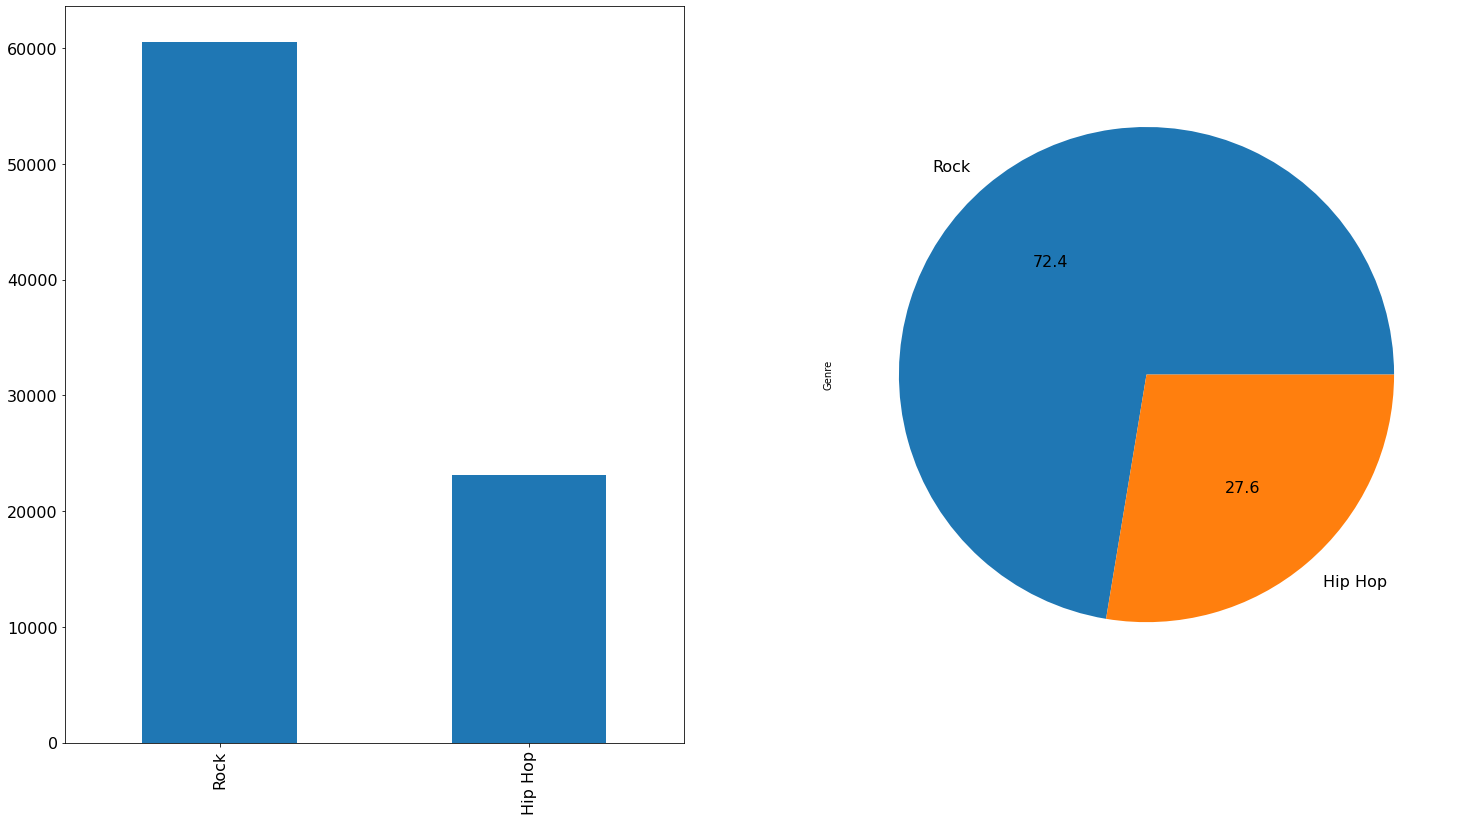

In [19]:
#procentowy rozklad 2 gatunkow muzycznych w zbiorze danych

genreCount = merged_inner['Genre'].value_counts()
fig, axarr = plt.subplots(1, 2)
fig.tight_layout()
genreCount.plot.pie( figsize=(12, 12), ax=axarr[1], fontsize=16, autopct='%.1f' )
genreCount.plot.bar( figsize=(22, 12), ax=axarr[0], fontsize=16 )
plt.show()

In [20]:
# sprawdza liczbę słów w każdej pisence
train = trainDF.copy()
train['word_count'] = train['Tekst'].apply(lambda x: len(str(x).split(" ")))
print(train[['Tekst','word_count']].head())
print(train['word_count'].max())
print(train['word_count'].min())
print(train['word_count'].mean())

                                               Tekst  word_count
0  I could feel at the time. There was no way of ...         145
1  Take me now, baby, here as I am. Hold me close...         238
2  These are. These are days you'll remember. Nev...         172
3  A lie to say, "O my mountain has coal veins an...         263
4  Trudging slowly over wet sand. Back to the ben...         118
3301
2
283.25838481115505


In [21]:
# sprawdź liczbę znaków
train['char_count'] = train['Tekst'].str.len() ## liczy tez spacje
train[['Tekst','char_count']].head()

,Tekst,char_count
0,I could feel at the time. There was no way of ...,755
1,"Take me now, baby, here as I am. Hold me close...",1253
2,These are. These are days you'll remember. Nev...,884
3,"A lie to say, ""O my mountain has coal veins an...",1283
4,Trudging slowly over wet sand. Back to the ben...,650


In [22]:
train.dtypes

Artist        object
Gatunek       object
Song          object
Tekst         object
word_count     int64
char_count     int64
dtype: object

In [23]:
# mapujemy typ danej na stringa(potrzeba do ponizszej funkcji avg_word())
train['Tekst']= train['Tekst'].map(str)

In [24]:
# sprawdź średnią liczbę znaków przypadających na jedno słowo

def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

train['avg_word'] = train['Tekst'].apply(lambda x: avg_word(x))
train[['Tekst','avg_word']].head()

,Tekst,avg_word
0,I could feel at the time. There was no way of ...,4.213793
1,"Take me now, baby, here as I am. Hold me close...",4.268908
2,These are. These are days you'll remember. Nev...,4.145349
3,"A lie to say, ""O my mountain has coal veins an...",3.882129
4,Trudging slowly over wet sand. Back to the ben...,4.516949


In [25]:
# sprawdź liczbę słów ze stoplisty (popularne angielskie słowa, które nie zawierają dodatkowej informacji dla modelu)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

train['stopwords'] = train['Tekst'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['Tekst','stopwords']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Tekst,stopwords
0,I could feel at the time. There was no way of ...,46
1,"Take me now, baby, here as I am. Hold me close...",82
2,These are. These are days you'll remember. Nev...,66
3,"A lie to say, ""O my mountain has coal veins an...",107
4,Trudging slowly over wet sand. Back to the ben...,39


In [26]:
# sprawdź liczbę znaków numerycznych

train['numerics'] = train['Tekst'].apply(lambda x: len([x for x in x.split(' ') if x.isnumeric()]))
print(train[['Tekst','numerics']].head())
print(train['numerics'].max())
print(train['numerics'].min())
print(train['numerics'].mean())

                                               Tekst  numerics
0  I could feel at the time. There was no way of ...         0
1  Take me now, baby, here as I am. Hold me close...         0
2  These are. These are days you'll remember. Nev...         0
3  A lie to say, "O my mountain has coal veins an...         1
4  Trudging slowly over wet sand. Back to the ben...         0
66
0
0.27567419019511785


In [27]:
# sprawdź liczbę wielkich liter

train['upper'] = train['Tekst'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
print(train[['Tekst','upper']].head())

train['capital'] = train['Tekst'].apply(lambda x: len([x for x in x.split(' ') if x[0].isupper()]))
print(train['capital'].max())
print(train['capital'].min())
print(train['capital'].mean())

                                               Tekst  upper
0  I could feel at the time. There was no way of ...      1
1  Take me now, baby, here as I am. Hold me close...      7
2  These are. These are days you'll remember. Nev...      2
3  A lie to say, "O my mountain has coal veins an...     12
4  Trudging slowly over wet sand. Back to the ben...      2
1126
0
55.10742833928764


In [28]:
# sprawdź liczbę znaków interpunkcyjnych

train['punctuation'] = train['Tekst'].apply(lambda x: len(re.findall(r'[\.,?!;:]', x)))
print(train[['Tekst','upper']].head())

train['punctuation'] = train['Tekst'].apply(lambda x: len([x for x in x.split(' ') if x[0].isupper()]))
print(train['punctuation'].max())
print(train['punctuation'].min())
print(train['punctuation'].mean())

                                               Tekst  upper
0  I could feel at the time. There was no way of ...      1
1  Take me now, baby, here as I am. Hold me close...      7
2  These are. These are days you'll remember. Nev...      2
3  A lie to say, "O my mountain has coal veins an...     12
4  Trudging slowly over wet sand. Back to the ben...      2
1126
0
55.10742833928764


### 3. Normalizacja tekstu

In [29]:
# ujednolicenie pisowni - zamień wielkie litery na małe

trainDFRaw = trainDF.copy()
trainDF['Tekst']= trainDF['Tekst'].map(str)
trainDF['Tekst'] = trainDF['Tekst'].apply(lambda x: " ".join(x.lower() for x in x.split()))
trainDF['Tekst'].head()

0    i could feel at the time. there was no way of ...
1    take me now, baby, here as i am. hold me close...
2    these are. these are days you'll remember. nev...
3    a lie to say, "o my mountain has coal veins an...
4    trudging slowly over wet sand. back to the ben...
Name: Tekst, dtype: object

In [30]:
#szukamy zwykłych nawiasów
text_in_round_brackets = sum(list(trainDF['Tekst'].map(lambda s: re.findall(r'\((.*?)\)',s))), [])
print('Number of round brackets: {}'.format(len(text_in_round_brackets)))

Number of round brackets: 188758


In [31]:
#przykładowe wyniki, decydujemy sie je zostawic
random.seed(0)
random.choices(text_in_round_brackets, k=20)

["everything's on us",
 'watch',
 'danger danger danger',
 'wa la',
 'my beat',
 'keyshia cole',
 'f.a.b.o',
 'jadakiss',
 'what do we have here now',
 'do',
 'oooh-oo-ooh',
 'all the time',
 'oh shit',
 'shawty',
 'kiss me baby',
 'nope',
 'ooo-ooo',
 'um yeah',
 "let's go!",
 "let's stop the world"]

In [32]:
#szukamy kwadratowych nawiasów
text_in_square_brackets = sum(list(trainDF['Tekst'].map(lambda s: re.findall(r'\[(.*?)\]',s))), [])
print('Number of square brackets: {}'.format(len(text_in_square_brackets)))

Number of square brackets: 74429


In [33]:
#przykładowe wyniki, decydujemy sie je pozniej usunąć
random.seed(0)
random.choices(text_in_square_brackets, k=20)

['money mike:',
 '?',
 'tray',
 'ja rule',
 'lo',
 'chorus',
 'talking:',
 'john cena',
 'chorus',
 'get down',
 '2x',
 "lil' kim",
 'amil',
 'eminem - chorus',
 "(duck down when we take aim, remainin on point. that's how we stay ahead of the game, like links and chains)",
 'kina grannis',
 '?',
 'avant',
 'r kelly (austin mahone) :',
 'x3']

In [34]:
#szukamy kręconcyh nawiasów
text_in_curly_brackets = sum(list(trainDF['Tekst'].map(lambda s: re.findall(r'\{(.*?)\}',s))), [])
print('Number of square brackets: {}'.format(len(text_in_curly_brackets)))

Number of square brackets: 2701


In [35]:
#przykładowe wyniki, decydujemy sie je zostawic
random.seed(0)
random.choices(text_in_curly_brackets, k=20)

['mother fucker',
 '"gangsta boogie!"',
 'oh yea, yea',
 '*lapse over chorus*',
 'chorus',
 'we ready to rock',
 '"you wouldn\'t get far"',
 '*"it was all.."*',
 'outlawz',
 'short dog',
 'repeat',
 'chorus (slight change)',
 'chuckles',
 '"gangsta boogie"',
 "little homey just didn't make way. got blazed on the strip",
 '*gunshot*',
 ':46',
 'chorus: ',
 'hook',
 '"and who the fuck are you?"']

In [36]:
# usuniecie nawiasow kwadratowych ale razem z tekstem w srodku!!!
trainDF['Tekst'] = trainDF['Tekst'].map(lambda s: re.sub(r'\[(.*?)\] ', '', s))

In [37]:
# usunięcie wszystkich znaków poza literami i biłymi znakami

trainDF['Tekst'] = trainDF['Tekst'].str.replace('[^\w\s]','')
trainDF['Tekst'].head()

0    i could feel at the time there was no way of k...
1    take me now baby here as i am hold me close an...
2    these are these are days youll remember never ...
3    a lie to say o my mountain has coal veins and ...
4    trudging slowly over wet sand back to the benc...
Name: Tekst, dtype: object

In [38]:
# usunięcie słów "stopwords"

english_stopwords = stopwords.words('english')

trainDF['Tekst'] = trainDF['Tekst'].apply(lambda x: " ".join(x for x in x.split() if x not in english_stopwords))

trainDF['Tekst'].head()

0    could feel time way knowing fallen leaves nigh...
1    take baby hold close try understand desire hun...
2    days youll remember never never since promise ...
3    lie say mountain coal veins beds dig 500 men a...
4    trudging slowly wet sand back bench clothes st...
Name: Tekst, dtype: object

In [39]:
# przygotowanie listy najczęściej wystepujących słów

freq = pd.Series(' '.join(trainDF['Tekst']).split()).value_counts()[:20]
freq

im       242166
dont     159884
like     150864
know     142308
love     117637
got      115306
get      112165
oh        87739
go        86652
one       75508
see       75281
yeah      75189
youre     73116
time      71673
baby      70393
cant      69619
never     68164
want      64821
back      62445
come      62345
dtype: int64

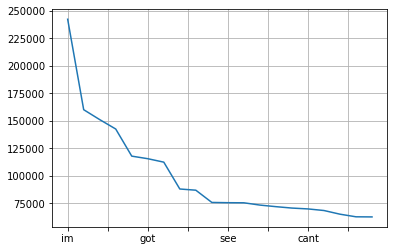

In [40]:
# wykres najczesciej wystepujacych slow
ax = plt.gca()
freq.plot(kind='line', ax=ax)
ax.grid()
plt.show()

In [41]:
# usunięcie słów najczęściej występujących

freq = list(freq.index)
trainDF['Tekst'] = trainDF['Tekst'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
trainDF['Tekst'].head()

0    could feel way knowing fallen leaves night say...
1    take hold close try understand desire hunger f...
2    days youll remember since promise whole world ...
3    lie say mountain coal veins beds dig 500 men a...
4    trudging slowly wet sand bench clothes stolen ...
Name: Tekst, dtype: object

In [42]:
# przygotowanie listy słów najrzadziej występujących

freq = pd.Series(' '.join(trainDF['Tekst']).split()).value_counts()[-20:]
freq

ontoss            1
sandsafe          1
capably           1
redoubt           1
chevill           1
stret             1
noisemakers       1
egofuck           1
doving            1
misdomener        1
queenly           1
syko              1
loveeee           1
isoldt            1
newishness        1
haikus            1
eisley            1
ltdrca            1
cmw               1
selfcontrolled    1
dtype: int64

In [43]:
# usuniecie słów najrzadziej wystepujących

freq = list(freq.index)
trainDF['Tekst'] = trainDF['Tekst'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
trainDF['Tekst'].head()

0    could feel way knowing fallen leaves night say...
1    take hold close try understand desire hunger f...
2    days youll remember since promise whole world ...
3    lie say mountain coal veins beds dig 500 men a...
4    trudging slowly wet sand bench clothes stolen ...
Name: Tekst, dtype: object

In [44]:
# poprawa pisowni (literówki)

from textblob import TextBlob
trainDF['Tekst'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    could feel way knowing fallen leaves night say...
1    take hold close try understand desire hunger f...
2    days you remember since promise whole world wa...
3    lie say mountain coal veins beds dig 500 men a...
4    grudging slowly wet sand bench clothes stolen ...
Name: Tekst, dtype: object

In [45]:
#lematyzacja - zamiana słów na ich podstawową formą

from textblob import Word
nltk.download('wordnet')

trainDF = trainDF.copy()
trainDF['Tekst'] = trainDF['Tekst'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
trainDF['Tekst'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    could feel way knowing fallen leaf night say t...
1    take hold close try understand desire hunger f...
2    day youll remember since promise whole world w...
3    lie say mountain coal vein bed dig 500 men ax ...
4    trudging slowly wet sand bench clothes stolen ...
Name: Tekst, dtype: object

In [46]:
trainDF.head(10)

,Artist,Gatunek,Song,Tekst
0,10000 Maniacs,Rock,More Than This,could feel way knowing fallen leaf night say t...
1,10000 Maniacs,Rock,Because The Night,take hold close try understand desire hunger f...
2,10000 Maniacs,Rock,These Are Days,day youll remember since promise whole world w...
3,10000 Maniacs,Rock,A Campfire Song,lie say mountain coal vein bed dig 500 men ax ...
4,10000 Maniacs,Rock,Everyday Is Like Sunday,trudging slowly wet sand bench clothes stolen ...
5,10000 Maniacs,Rock,Don't Talk,talk listen talk keep distance id rather hear ...
6,10000 Maniacs,Rock,Across The Fields,well left morning hundred pair wing light move...
7,10000 Maniacs,Rock,Planned Obsolescence,music dennis drewlyric natalie merchant scienc...
8,10000 Maniacs,Rock,Rainy Day,bended kneeive looked every window touched bot...
9,10000 Maniacs,Rock,Anthem For Doomed Youth,bell toll sentenced die stuttering rifle stifl...


### 3. Przygotowanie modelu

In [47]:
#czyscimy teksty ze znakow specjalnych za pomoca prostej funkcji z regexem, przyda sie pozniej
def cleanse (text):
    result = re.sub('[^a-zA-Z0-9 ]', ' ', text)
    return result

In [48]:
rock_songs = trainDF[trainDF['Gatunek']=='Rock']
rock_songs = rock_songs.dropna() # usuwamy niekompletene teksty
rock_songs = rock_songs[rock_songs['Tekst']!='Instrumental'].head(SONGS_PER_GENRE).applymap(cleanse) #usuwamy same insturmentale
rock_songs.head()

,Artist,Gatunek,Song,Tekst
0,10000 Maniacs,Rock,More Than This,could feel way knowing fallen leaf night say t...
1,10000 Maniacs,Rock,Because The Night,take hold close try understand desire hunger f...
2,10000 Maniacs,Rock,These Are Days,day youll remember since promise whole world w...
3,10000 Maniacs,Rock,A Campfire Song,lie say mountain coal vein bed dig 500 men ax ...
4,10000 Maniacs,Rock,Everyday Is Like Sunday,trudging slowly wet sand bench clothes stolen ...


In [49]:
hiphop_songs = trainDF[trainDF['Gatunek']=='Hip Hop']
hiphop_songs = hiphop_songs.dropna() # usuwamy niekompletene teksty
hiphop_songs = hiphop_songs[hiphop_songs['Tekst']!='Instrumental'].head(SONGS_PER_GENRE).applymap(cleanse) #usuwamy same insturmentale
hiphop_songs.head()

,Artist,Gatunek,Song,Tekst
3363,Beastie Boys,Hip Hop,Sabotage,stand planned set straight watergate stand roc...
3364,Beastie Boys,Hip Hop,Intergalactic,intergalactic planetary planetary intergalacti...
3365,Beastie Boys,Hip Hop,You Gotta Fight For Your Right To Party,kick verse 1 wake late school man wanna ask mo...
3366,Beastie Boys,Hip Hop,Sure Shot,wont stop mike rock sure shot ive brand new do...
3367,Beastie Boys,Hip Hop,No Sleep Till Brooklyn,chorus sleep til brooklyn foot pedal ever fals...


In [50]:
# sprawdzamy liczbe tekstow powinna zgadzac sie ze zmienna globalna na poczatku
print("Hip Hop -", len(hiphop_songs), "| Rock -",len(rock_songs))

Hip Hop - 20000 | Rock - 20000


In [51]:
#przygotuj treningowe dane poprzez wybranie rownej liczby
training_data = pd.concat([hiphop_songs.head(SONGS_PER_TRAINING), rock_songs.head(SONGS_PER_TRAINING)])

In [52]:
#stworz słownik słów
cv = CountVectorizer(strip_accents='ascii', lowercase=True, stop_words='english', analyzer='word') #stworz objekt CountVectorizer
cv.fit(training_data['Tekst'].values)

#stworz reprezentacje BOW
bow = cv.transform(training_data['Tekst'].values) 
print(bow.shape[0], 'samples x ',bow.shape[1],'words in vocabulary' )

4000 samples x  24123 words in vocabulary


In [53]:
#stworz klasyfikator obietku ML
models = {'Logistic Regression':LogisticRegression(max_iter=600), 'Linear SVC':LinearSVC(max_iter=15000),'Decision Tree': DecisionTreeClassifier(), 'Gradient Descent': SGDClassifier()}
for the_model in models.keys():
    print ("Training", the_model)
    models[the_model].fit(bow.toarray(), training_data['Gatunek'])

Training Logistic Regression
Training Linear SVC


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Training Decision Tree
Training Gradient Descent


In [54]:
#przygotuj dane do testowania
test_data=pd.concat([hiphop_songs.iloc[SONGS_PER_TRAINING:SONGS_PER_TRAINING+SONGS_PER_TESTING], rock_songs.iloc[SONGS_PER_TRAINING:SONGS_PER_TRAINING+SONGS_PER_TESTING]])

#przekonwertuj tekst to reprezentacji BOW
test_bow = cv.transform(test_data['Tekst'].values) 

In [55]:
#sproboj przewidziec gatunek muzyczny na podstawie tekstu
accuracy = {}
pg = test_data[['Artist', 'Song','Gatunek']]
accuracy_compare = {}
for the_model in models.keys():
    print("Kalkulowanie",the_model)
    pred_genre= models[the_model].predict(test_bow.toarray())
    pg[the_model]=pred_genre
    accuracy[the_model]=accuracy_score(test_data['Gatunek'],pred_genre)
print(accuracy)

Kalkulowanie Logistic Regression
Kalkulowanie Linear SVC
Kalkulowanie Decision Tree
Kalkulowanie Gradient Descent
{'Logistic Regression': 0.7375, 'Linear SVC': 0.7175, 'Decision Tree': 0.7725, 'Gradient Descent': 0.73}


In [56]:
df_compare = pd.DataFrame(accuracy, index = ['precision'])
df_compare.head()

,Logistic Regression,Linear SVC,Decision Tree,Gradient Descent
precision,0.7375,0.7175,0.7725,0.73


<AxesSubplot:>

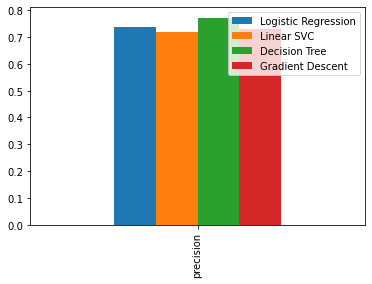

In [57]:
#porowanianie wynikow na wykresie
df_compare.plot(kind='bar')

In [58]:
#podaj fragment piosenki
podaj_tekst = input()

#przetranswormuj je w BOW
user_bow = cv.transform([cleanse(podaj_tekst)]) 

#sprawdz tekst na wytrenowanych modelach
for the_model in models.keys():
    print(the_model, models[the_model].predict(user_bow))

night
Logistic Regression ['Hip Hop']
Linear SVC ['Hip Hop']
Decision Tree ['Hip Hop']
Gradient Descent ['Rock']


### 4. Analiza wyników i własne obserwacje

In [59]:
"""
 1. Wybor odpowienich danych oraz ich przygotowanie ma kluczowe znaczenie dla calego projektu,
 tutaj moznaby było poszukac lepszego zbioru utworów.
 2. Pomimo dokładnej normalizacji tekstu i tak wkradną się tam niechciane "śmieci".
 3. Dłuższe utwory(tekst) nie zawsze oznaczają wiekszą dokładność.
 4. Wiekszy zbior danych nie zawsze oznacza większą dokładność.
 5. Pod wzgledem dokładnosci wygyrywa regresja logistyczna, restza modeli nie wypadła  gorzej, wszystkie wyniki sa zblizone.
 6. Spodziwalismy sie gorszych wynikow jesli chodzi o dokładnosc testownych modeli.
 7. Zdziwiła tez nas średnia liczba liter w słowie, pozniewaz dla wielu utowrów nie przkroczyła ona średniej 4.0
 8. Cięzko było okreslic czy słowa w nawiasach zaliczaja sie do slow piosenki czy nie
"""

'\n 1. Wybor odpowienich danych oraz ich przygotowanie ma kluczowe znaczenie dla calego projektu,\n tutaj moznaby było poszukac lepszego zbioru utworów.\n 2. Pomimo dokładnej normalizacji tekstu i tak wkradną się tam niechciane "śmieci".\n 3. Dłuższe utwory(tekst) nie zawsze oznaczają wiekszą dokładność.\n 4. Wiekszy zbior danych nie zawsze oznacza większą dokładność.\n 5. Pod wzgledem dokładnosci wygyrywa regresja logistyczna, restza modeli nie wypadła  gorzej, wszystkie wyniki sa zblizone.\n 6. Spodziwalismy sie gorszych wynikow jesli chodzi o dokładnosc testownych modeli.\n 7. Zdziwiła nas średnia tez liczba liter w słowie, pozniewaz dla wielu utowrów nie przkroczyła ona średniej 4.0\n'